# RNN Example Github Link: 
https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

2025-03-19 22:12:51.909834: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 22:12:51.912950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 22:12:51.920945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742422371.934288    1259 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742422371.938298    1259 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742422371.949706    1259 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Python version: 3.12.9
Tensorflow version: 2.19.0
Keras version: 3.9.0


# Download the dataset

In [2]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

/tmp/.keras/datasets/shakespeare.txt


# Analyze the dataset

In [3]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Process the dataset

# Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [6]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [7]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


# Create training sequences

In [9]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [10]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


2025-03-19 22:12:54.127030: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-03-19 22:12:54.160701: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


2025-03-19 22:12:55.089638: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

In [13]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [14]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


2025-03-19 22:12:56.896052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [16]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

In [17]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 (np.str_('F'))
  expected output: 47 (np.str_('i'))
Step  1
  input: 47 (np.str_('i'))
  expected output: 56 (np.str_('r'))
Step  2
  input: 56 (np.str_('r'))
  expected output: 57 (np.str_('s'))
Step  3
  input: 57 (np.str_('s'))
  expected output: 58 (np.str_('t'))
Step  4
  input: 58 (np.str_('t'))
  expected output: 1 (np.str_(' '))


# Split training sequences into batches

We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [18]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [19]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [20]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[45 56 47 ... 13 24 33]
 [44  1 20 ... 39 51  1]
 [56  1 47 ... 56 53 39]
 ...
 [ 1 63 53 ... 53 52  8]
 [57 47 57 ... 58 53  1]
 [42  0 16 ... 39 52 42]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[56 47 43 ... 24 33 31]
 [ 1 20 43 ... 51  1 41]
 [ 1 47 52 ... 53 39 52]
 ...
 [63 53 59 ... 52  8  0]
 [47 57 58 ... 53  1 63]
 [ 0 16 47 ... 52 42 57]], shape=(64, 100), dtype=int64)


In [21]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

# Build the model

Use tf.keras.Sequential to define the model. For this simple example three layers are used to define our model:

tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
tf.keras.layers.LSTM: A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [22]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[0 2 8 4 6 7 3 3]
 [8 3 7 5 1 7 4 9]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.04668866  0.03536827  0.00056974  0.01664679  0.01947509]
  [ 0.01586229  0.04528096 -0.01220976 -0.04676864 -0.04299035]
  [-0.04794359  0.03331646 -0.00598552  0.0306597   0.02357526]
  [-0.00769838 -0.01102544  0.04531623 -0.03525064 -0.04556319]
  [ 0.04949411 -0.03631841 -0.0410624  -0.01631735 -0.02080142]
  [-0.04718274 -0.02040367 -0.01882841  0.0186975   0.0125769 ]
  [-0.02191516  0.04962126  0.02698841 -0.04292355  0.04983444]
  [-0.02191516  0.04962126  0.02698841 -0.04292355  0.04983444]]

 [[-0.04794359  0.03331646 -0.00598552  0.0306597   0.02357526]
  [-0.02191516  0.04962126  0.02698841 -0.04292355  0.04983444]
  [-0.04718274 -0.02040367 -0.01882841  0.0186975   0.0125769 ]
  [ 0.01213606 -0.04637331  0.02473767  0.03022995 -0.02192633]
  [ 0.00177459 -0.00786291 -0.00263095  0.02166161 -0

/var/data/python/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [79]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    batch_input_shape=[batch_size, None]
  ))

  model.add(tf.keras.layers.LSTM(
    units=rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
  ))

  model.add(tf.keras.layers.Dense(vocab_size))

  return model

In [80]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

ValueError: Unrecognized keyword arguments passed to Embedding: {'batch_input_shape': [64, None]}

In [81]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [82]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

# Try the model

In [83]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [84]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 3.8375147e-03  4.1271849e-03  3.8424181e-03 -4.2190435e-03
 -4.1784314e-03 -1.8455449e-03  6.8496447e-04 -6.6555105e-04
  4.8309164e-03 -4.3769460e-03  3.9018511e-03  3.3952857e-03
 -3.4864768e-03 -2.3510475e-03 -2.8463328e-05 -4.4220872e-03
 -1.1006200e-03  5.5054268e-03 -5.2790856e-05 -1.3550913e-03
 -2.6596491e-03 -3.0308580e-03 -7.8531157e-05  2.1691748e-03
  9.2493440e-04 -1.8495603e-03 -4.8714858e-03  4.8001541e-04
  1.3454026e-03 -9.2647533e-04  6.9562445e-04  1.1495443e-03
 -3.6784066e-03  7.8707878e-03  2.3236689e-03  4.1967412e-03
 -2.6639521e-03 -1.3098123e-03  5.6513874e-03  5.8956360e-03
  5.3545036e-03 -9.5951324e-04  2.9797759e-03 -5.1464641e-04
 -3.9523654e-04 -1.1718827e-03  2.7786964e-03 -2.9290468e-03
  1.2272120e-03 -5.8738221e-03 -1.2988437e-03  6.3779792e-03
  3.1271349e-03  2.8377513e-03  1.2812599e-03 -3.9937017e-03
  8.7719108e-04 -2.0600760e-03 -2.5293394e-04 -1.3822129e-03
  3.4104737e-03  

In [85]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 1 2 1 2]], shape=(1, 5), dtype=int64)


In [86]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [87]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [88]:
sampled_indices

array([19, 34, 26, 29, 15, 54, 56, 25, 53, 31, 15, 58, 27, 29,  4, 40, 60,
       38,  2, 33, 62, 40, 50, 62, 38, 28, 64, 40, 32, 27,  9, 47,  5, 57,
       28,  2, 17, 12, 38,  1, 61, 59, 59, 61, 32, 52, 18, 20, 34, 29, 51,
       46,  8, 50, 56, 49, 20, 43, 21, 55, 55, 12, 44, 39, 28, 23, 11, 30,
       30, 32, 38, 31,  8, 57, 50, 46,  2, 38, 45, 40, 48, 64, 14, 59, 29,
       32, 10,  5, 33, 12, 11, 50, 19, 33, 58, 33, 61, 38,  7, 51])

In [89]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "uct now!\nNow, Tybalt, take the villain back again,\nThat late thou gavest me; for Mercutio's soul\nIs "

Next char prediction:
 "GVNQCprMoSCtOQ&bvZ!UxblxZPzbTO3i'sP!E?Z wuuwTnFHVQmh.lrkHeIqq?faPK;RRTZS.slh!ZgbjzBuQT:'U?;lGUtUwZ-m"


In [90]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 59 (np.str_('u'))
  next predicted: 1 (np.str_('G'))
Prediction  1
  input: 41 (np.str_('c'))
  next predicted: 1 (np.str_('V'))
Prediction  2
  input: 58 (np.str_('t'))
  next predicted: 1 (np.str_('N'))
Prediction  3
  input: 1 (np.str_(' '))
  next predicted: 1 (np.str_('Q'))
Prediction  4
  input: 52 (np.str_('n'))
  next predicted: 1 (np.str_('C'))


# Train the model
At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

In [91]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174897


In [92]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

Configure checkpoints

In [93]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}.weights.h5')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

In [94]:
# This was purposely set to 3 as my laptop took to much time to run this when i was experirmemnting with this notebook.
EPOCHS=3

In [96]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - loss: 2.1904
Epoch 2/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - loss: 1.7540
Epoch 3/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - loss: 1.5589


In [97]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

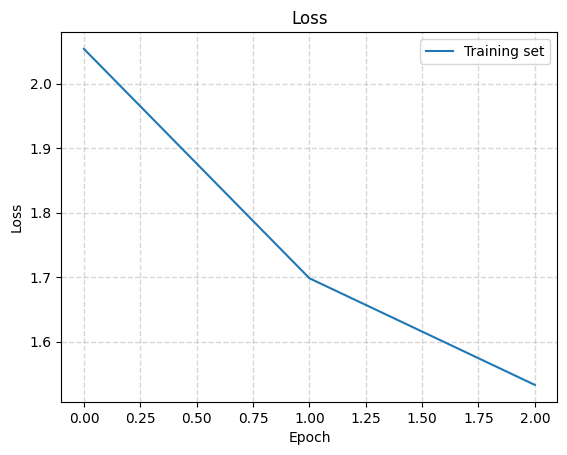

In [98]:
render_training_history(history)

# Generate text
# Restore the latest checkpoint
To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint.

In [99]:
tf.train.latest_checkpoint(checkpoint_dir)

In [101]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

ValueError: Unrecognized keyword arguments passed to Embedding: {'batch_input_shape': [1, None]}

In [102]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (64, 100, 256)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (64, 100, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 100, 65)          │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,990,725 (61.00 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,660,484 (40.67 MB)

# The prediction loop
The following code block generates the text:

    It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

    Get the prediction distribution of the next character using the start string and the RNN state.

    Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

    The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

In [103]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [104]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

AttributeError: 'Sequential' object has no attribute 'reset_states'

In [105]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

AttributeError: 'Sequential' object has no attribute 'reset_states'

# Save the model

In [106]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')